# GoudaCell Interactive Segmentation

This notebook allows you to test segmentation parameters on a few images.
Once you find good parameters, it automatically generates a config file for batch processing.

**⚠️ Set kernel to "goudacell" (top right) before running!**

**Requirements:**
- Run this on a GPU node via SLURM (see `scripts/jupyter_gpu.sh`)
- Install goudacell with either `cellpose3` or `cellpose4` extras

**Note:** This config is designed for images with similar setups (same channels, similar cell sizes). Re-run this notebook for different image types.

In [ ]:
# Check GPU availability
import torch

print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

In [ ]:
# Check goudacell and cellpose versions
import goudacell
from goudacell.segment import get_cellpose_version

print(f"GoudaCell version: {goudacell.__version__}")
cp_version = get_cellpose_version()
print(f"Cellpose version: {cp_version[0]}.{cp_version[1]}")

if cp_version[0] >= 4:
    print("Available models: cpsam (auto-selected)")
else:
    print("Available models: cyto3, nuclei, cyto2, cyto (auto-selected based on mode)")

---
## 1. Load Test Image

First, let's load and visualize your image to see the available channels.
This helps you choose the right channel parameters in the next section.

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

from goudacell import load_image

# ============================================
# CONFIGURE YOUR DATA PATHS HERE
# ============================================
# Option 1: Set a specific test image path
TEST_IMAGE = None  # e.g., Path("path/to/your/image.tif")

# Option 2: Auto-select from INPUT_DIR (if TEST_IMAGE is None)
INPUT_DIR = Path("../data")
FILE_PATTERN = "*.tif"  # or "*.nd2", "*.dv"

# ============================================
# Resolve test image path
if TEST_IMAGE is not None:
    test_image_path = Path(TEST_IMAGE)
    print(f"Using specified image: {test_image_path}")
else:
    available_files = sorted(INPUT_DIR.glob(FILE_PATTERN))
    if not available_files:
        raise FileNotFoundError(f"No files matching '{FILE_PATTERN}' in {INPUT_DIR}")
    test_image_path = available_files[0]
    print(f"Auto-selected: {test_image_path.name}")
    print(f"Total files in directory: {len(available_files)}")

# Load image (load all channels, with z-projection)
image = load_image(test_image_path, channel=None, z_project=True)
print(f"Image shape: {image.shape}")
print(f"Image dtype: {image.dtype}")

### Visualize Channels

Review the channels below to identify:
- **Nuclei channel**: Usually DAPI (bright nuclei)
- **Cytoplasm channel**: Membrane markers, cytoplasmic stains, etc.

In [ ]:
# Visualize all channels
n_channels = image.shape[0] if image.ndim == 3 else 1
fig, axes = plt.subplots(1, min(n_channels, 4), figsize=(16, 4))

if image.ndim == 2:
    axes.imshow(image, cmap="gray")
    axes.set_title("Channel 0")
    axes.axis("off")
else:
    if n_channels == 1:
        axes = [axes]
    for i, ax in enumerate(axes if hasattr(axes, "__iter__") else [axes]):
        if i < image.shape[0]:
            ax.imshow(image[i], cmap="gray")
            ax.set_title(f"Channel {i}")
        ax.axis("off")

plt.tight_layout()
plt.show()

print("\nNote the channel numbers above for the configuration section below.")

---
## 2. Configuration

**Set all your parameters here** based on the channels you saw above.

**Segmentation modes:**
- `"nuclei"` - Segment nuclei only (uses nuclei model)
- `"cells"` - Segment cells only (uses cyto model, default)
- `"dual"` - Segment both nuclei AND cells (outputs two masks)

In [ ]:
# ============================================
# SEGMENTATION MODE
# ============================================
SEGMENTATION_MODE = "dual"  # "nuclei", "cells", or "dual"

# ============================================
# OUTPUT PATH
# ============================================
OUTPUT_DIR = Path("../data/masks")

# ============================================
# CHANNEL SELECTION (view channels above first!)
# ============================================
NUCLEI_CHANNEL = 0  # Channel with nuclei (usually DAPI)
CYTO_CHANNEL = 1  # Channel with cytoplasm/membrane

# ============================================
# DIAMETER (pixels)
# ============================================
NUCLEI_DIAMETER = 15.0  # Nuclear diameter (typically smaller)
CELL_DIAMETER = 40.0  # Cell diameter (typically larger)

# ============================================
# THRESHOLDS
# ============================================
# Nuclei thresholds (often need tighter settings)
NUCLEI_FLOW_THRESHOLD = 0.4  # Lower = fewer nuclei
NUCLEI_CELLPROB_THRESHOLD = 0.0  # Higher = fewer nuclei

# Cell thresholds
CELL_FLOW_THRESHOLD = 0.4  # Lower = fewer cells
CELL_CELLPROB_THRESHOLD = 0.0  # Higher = fewer cells

# ============================================
# OTHER PARAMETERS
# ============================================
GPU = True
REMOVE_EDGE_CELLS = False  # Keep edge cells for interactive exploration
Z_PROJECT = True

# ============================================
# Auto-select models based on cellpose version
if cp_version[0] >= 4:
    NUCLEI_MODEL = "cpsam"
    CELL_MODEL = "cpsam"
else:
    NUCLEI_MODEL = "nuclei"
    CELL_MODEL = "cyto3"

# ============================================
print("Configuration set!")
print(f"  Mode: {SEGMENTATION_MODE}")
print(f"  Models: nuclei={NUCLEI_MODEL}, cells={CELL_MODEL}")
if SEGMENTATION_MODE == "dual":
    print(
        f"  Nuclei: ch={NUCLEI_CHANNEL}, d={NUCLEI_DIAMETER}, "
        f"flow={NUCLEI_FLOW_THRESHOLD}, prob={NUCLEI_CELLPROB_THRESHOLD}"
    )
    print(
        f"  Cells:  ch={CYTO_CHANNEL}, d={CELL_DIAMETER}, "
        f"flow={CELL_FLOW_THRESHOLD}, prob={CELL_CELLPROB_THRESHOLD}"
    )
elif SEGMENTATION_MODE == "nuclei":
    print(f"  Channel: {NUCLEI_CHANNEL}, Diameter: {NUCLEI_DIAMETER}")
    print(f"  Flow: {NUCLEI_FLOW_THRESHOLD}, Cellprob: {NUCLEI_CELLPROB_THRESHOLD}")
else:  # cells
    print(f"  Channel: {CYTO_CHANNEL}, Diameter: {CELL_DIAMETER}")
    print(f"  Flow: {CELL_FLOW_THRESHOLD}, Cellprob: {CELL_CELLPROB_THRESHOLD}")

---
## 3. Estimate Diameter (Cellpose 3.x only)

Automatic diameter estimation is only available with Cellpose 3.x.

In [ ]:
from goudacell.segment import estimate_diameter, get_cellpose_version

if get_cellpose_version()[0] < 4:
    print("Estimating diameters (Cellpose 3.x only)...")
    try:
        # Estimate nuclei diameter
        nuclei_img = image[NUCLEI_CHANNEL] if image.ndim == 3 else image
        estimated_nuclei = estimate_diameter(nuclei_img, model=NUCLEI_MODEL, gpu=GPU)
        print(
            f"Estimated nuclei diameter: {estimated_nuclei:.1f} pixels (current: {NUCLEI_DIAMETER})"
        )

        # Estimate cell diameter
        cyto_img = image[CYTO_CHANNEL] if image.ndim == 3 else image
        estimated_cell = estimate_diameter(cyto_img, model=CELL_MODEL, gpu=GPU)
        print(f"Estimated cell diameter: {estimated_cell:.1f} pixels (current: {CELL_DIAMETER})")

        print("\nUpdate diameters in Section 2 if needed, then re-run from there.")
    except Exception as e:
        print(f"Could not estimate diameter: {e}")
else:
    print("Automatic diameter estimation not available in Cellpose 4.x")
    print(f"Current settings: NUCLEI_DIAMETER={NUCLEI_DIAMETER}, CELL_DIAMETER={CELL_DIAMETER}")
    print("Adjust manually based on your images.")

---
## 4. Run Segmentation

Run segmentation with your configured parameters. The code handles all three modes automatically.

In [7]:
from goudacell import segment, segment_nuclei_and_cells

if SEGMENTATION_MODE == "dual":
    # Dual mode: segment both nuclei and cells
    nuclei_masks, cell_masks = segment_nuclei_and_cells(
        image,
        nuclei_channel=NUCLEI_CHANNEL,
        cyto_channel=CYTO_CHANNEL,
        nuclei_diameter=NUCLEI_DIAMETER,
        cell_diameter=CELL_DIAMETER,
        cell_model=CELL_MODEL,
        nuclei_model=NUCLEI_MODEL,
        nuclei_flow_threshold=NUCLEI_FLOW_THRESHOLD,
        nuclei_cellprob_threshold=NUCLEI_CELLPROB_THRESHOLD,
        cell_flow_threshold=CELL_FLOW_THRESHOLD,
        cell_cellprob_threshold=CELL_CELLPROB_THRESHOLD,
        gpu=GPU,
        remove_edge_cells=REMOVE_EDGE_CELLS,
    )
    n_nuclei = len(np.unique(nuclei_masks)) - 1
    n_cells = len(np.unique(cell_masks)) - 1
    print(f"Found {n_nuclei} nuclei and {n_cells} cells")
    masks = cell_masks  # For compatibility with later cells
elif SEGMENTATION_MODE == "nuclei":
    # Nuclei mode: segment nuclei only
    seg_image = image[NUCLEI_CHANNEL] if image.ndim == 3 else image

    masks = segment(
        seg_image,
        diameter=NUCLEI_DIAMETER,
        model=NUCLEI_MODEL,
        flow_threshold=NUCLEI_FLOW_THRESHOLD,
        cellprob_threshold=NUCLEI_CELLPROB_THRESHOLD,
        gpu=GPU,
        remove_edge_cells=REMOVE_EDGE_CELLS,
    )
    n_objects = len(np.unique(masks)) - 1
    print(f"Found {n_objects} nuclei")
else:  # cells mode
    # Cells mode: segment cells using cyto channel
    seg_image = image[CYTO_CHANNEL] if image.ndim == 3 else image

    masks = segment(
        seg_image,
        diameter=CELL_DIAMETER,
        model=CELL_MODEL,
        flow_threshold=CELL_FLOW_THRESHOLD,
        cellprob_threshold=CELL_CELLPROB_THRESHOLD,
        gpu=GPU,
        remove_edge_cells=REMOVE_EDGE_CELLS,
    )
    n_objects = len(np.unique(masks)) - 1
    print(f"Found {n_objects} cells")

Found 6 nuclei and 6 cells


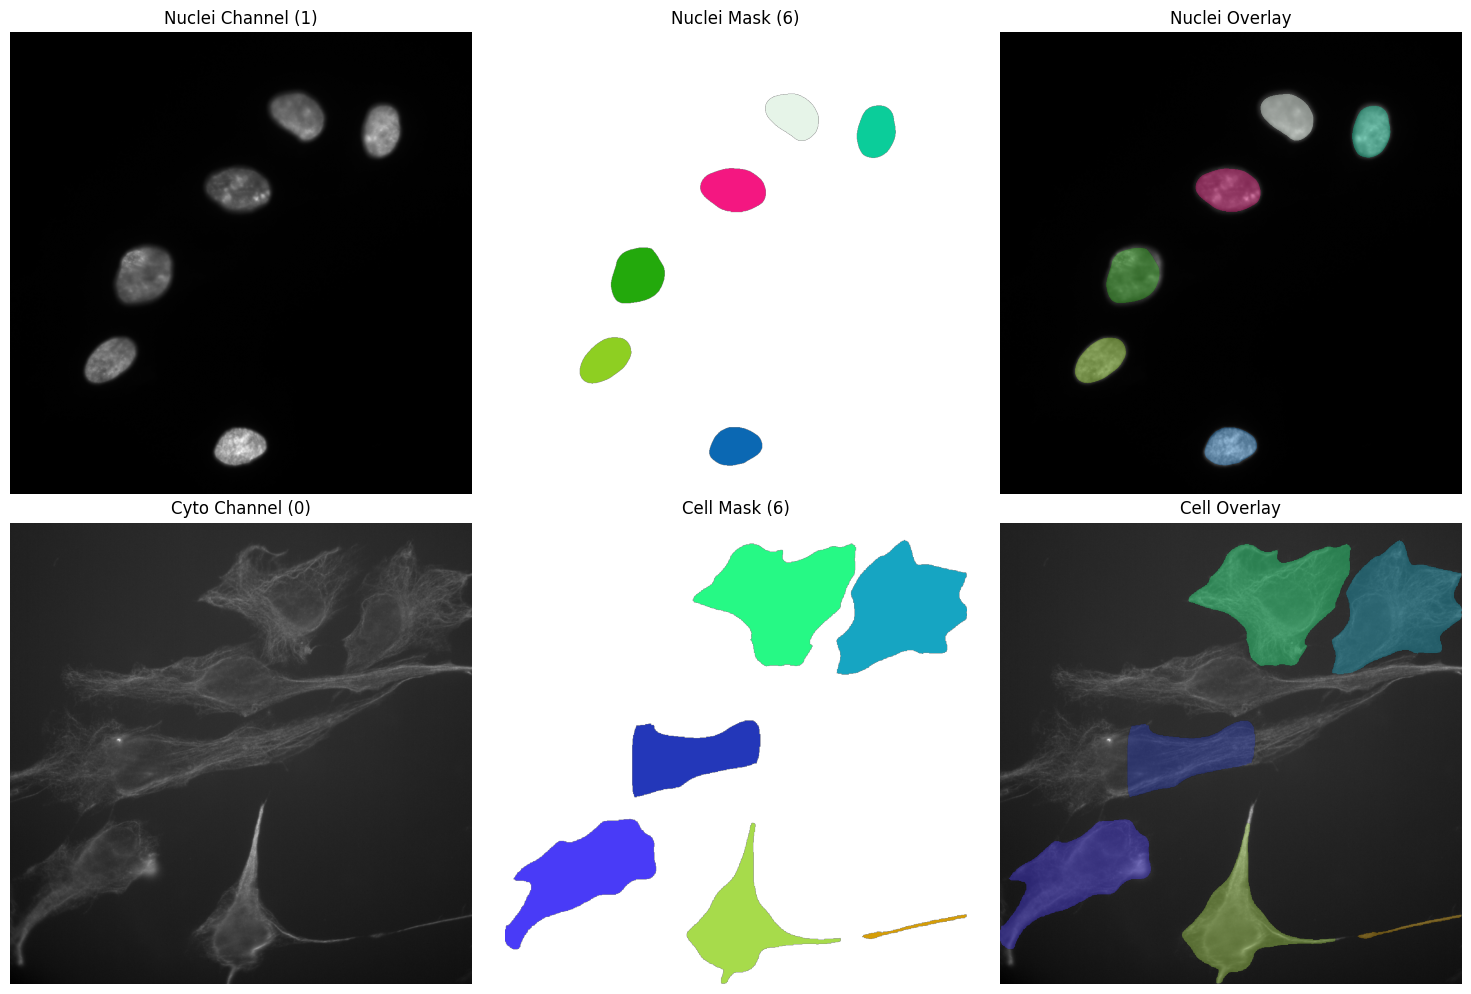

In [8]:
# Visualize Results
from goudacell import make_mask_cmap

if SEGMENTATION_MODE == "dual":
    # Dual mode: 2 rows (nuclei row + cells row)
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    nuclei_cmap = make_mask_cmap(nuclei_masks)
    cell_cmap = make_mask_cmap(cell_masks)

    # Row 1: Nuclei
    axes[0, 0].imshow(image[NUCLEI_CHANNEL], cmap="gray")
    axes[0, 0].set_title(f"Nuclei Channel ({NUCLEI_CHANNEL})")
    axes[0, 0].axis("off")

    axes[0, 1].imshow(nuclei_masks, cmap=nuclei_cmap)
    axes[0, 1].set_title(f"Nuclei Mask ({n_nuclei})")
    axes[0, 1].axis("off")

    axes[0, 2].imshow(image[NUCLEI_CHANNEL], cmap="gray")
    axes[0, 2].imshow(nuclei_masks, cmap=nuclei_cmap, alpha=0.4)
    axes[0, 2].set_title("Nuclei Overlay")
    axes[0, 2].axis("off")

    # Row 2: Cells
    axes[1, 0].imshow(image[CYTO_CHANNEL], cmap="gray")
    axes[1, 0].set_title(f"Cyto Channel ({CYTO_CHANNEL})")
    axes[1, 0].axis("off")

    axes[1, 1].imshow(cell_masks, cmap=cell_cmap)
    axes[1, 1].set_title(f"Cell Mask ({n_cells})")
    axes[1, 1].axis("off")

    axes[1, 2].imshow(image[CYTO_CHANNEL], cmap="gray")
    axes[1, 2].imshow(cell_masks, cmap=cell_cmap, alpha=0.4)
    axes[1, 2].set_title("Cell Overlay")
    axes[1, 2].axis("off")
else:
    # Single mode visualization
    n = len(np.unique(masks)) - 1
    cmap = make_mask_cmap(masks)

    if SEGMENTATION_MODE == "nuclei":
        display_img = image[NUCLEI_CHANNEL] if image.ndim == 3 else image
        label = "nuclei"
    else:
        display_img = image[CYTO_CHANNEL] if image.ndim == 3 else image
        label = "cells"

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(display_img, cmap="gray")
    axes[0].set_title("Original")
    axes[0].axis("off")

    axes[1].imshow(masks, cmap=cmap)
    axes[1].set_title(f"Segmentation ({n} {label})")
    axes[1].axis("off")

    axes[2].imshow(display_img, cmap="gray")
    axes[2].imshow(masks, cmap=cmap, alpha=0.4)
    axes[2].set_title("Overlay")
    axes[2].axis("off")

plt.tight_layout()
plt.show()

---
## 5. Parameter Sweeps (Optional)

Test different parameter values to find optimal settings.

### 5A. Single Mode Sweeps (nuclei or cells)

Skip this section if using dual mode.

In [9]:
# Parameter sweep (single mode: nuclei or cells)
# Change SWEEP_PARAM to test different parameters
if SEGMENTATION_MODE != "dual":
    SWEEP_PARAM = "diameter"  # Options: "diameter", "flow", "cellprob"

    if SEGMENTATION_MODE == "nuclei":
        model, base_diameter = NUCLEI_MODEL, NUCLEI_DIAMETER
        base_flow, base_prob = NUCLEI_FLOW_THRESHOLD, NUCLEI_CELLPROB_THRESHOLD
        display_img = image[NUCLEI_CHANNEL] if image.ndim == 3 else image
        label = "nuclei"
    else:
        model, base_diameter = CELL_MODEL, CELL_DIAMETER
        base_flow, base_prob = CELL_FLOW_THRESHOLD, CELL_CELLPROB_THRESHOLD
        display_img = image[CYTO_CHANNEL] if image.ndim == 3 else image
        label = "cells"

    # Define sweep values
    sweeps = {
        "diameter": ([10, 15, 20, 25] if SEGMENTATION_MODE == "nuclei" else [30, 40, 50, 60], "d"),
        "flow": ([0.2, 0.4, 0.6, 0.8], "flow"),
        "cellprob": ([-1.0, 0.0, 1.0, 2.0], "prob"),
    }
    values, param_label = sweeps[SWEEP_PARAM]

    fig, axes = plt.subplots(1, len(values), figsize=(4 * len(values), 4))
    for i, v in enumerate(values):
        d = v if SWEEP_PARAM == "diameter" else base_diameter
        ft = v if SWEEP_PARAM == "flow" else base_flow
        cp = v if SWEEP_PARAM == "cellprob" else base_prob

        masks_test = segment(
            display_img, diameter=d, model=model, flow_threshold=ft, cellprob_threshold=cp, gpu=GPU
        )
        n = len(np.unique(masks_test)) - 1

        axes[i].imshow(display_img, cmap="gray")
        axes[i].imshow(masks_test, cmap=make_mask_cmap(masks_test), alpha=0.4)
        axes[i].set_title(f"{param_label}={v} ({n} {label})")
        axes[i].axis("off")

    plt.suptitle(f"{SWEEP_PARAM.title()} sweep ({SEGMENTATION_MODE} mode)")
    plt.tight_layout()
    plt.show()
else:
    print("Skip this cell for dual mode - see Section 5B below.")

Skip this cell for dual mode - see Section 5B below.


### 5B. Dual Mode Sweeps

Skip this section if using nuclei or cells mode.

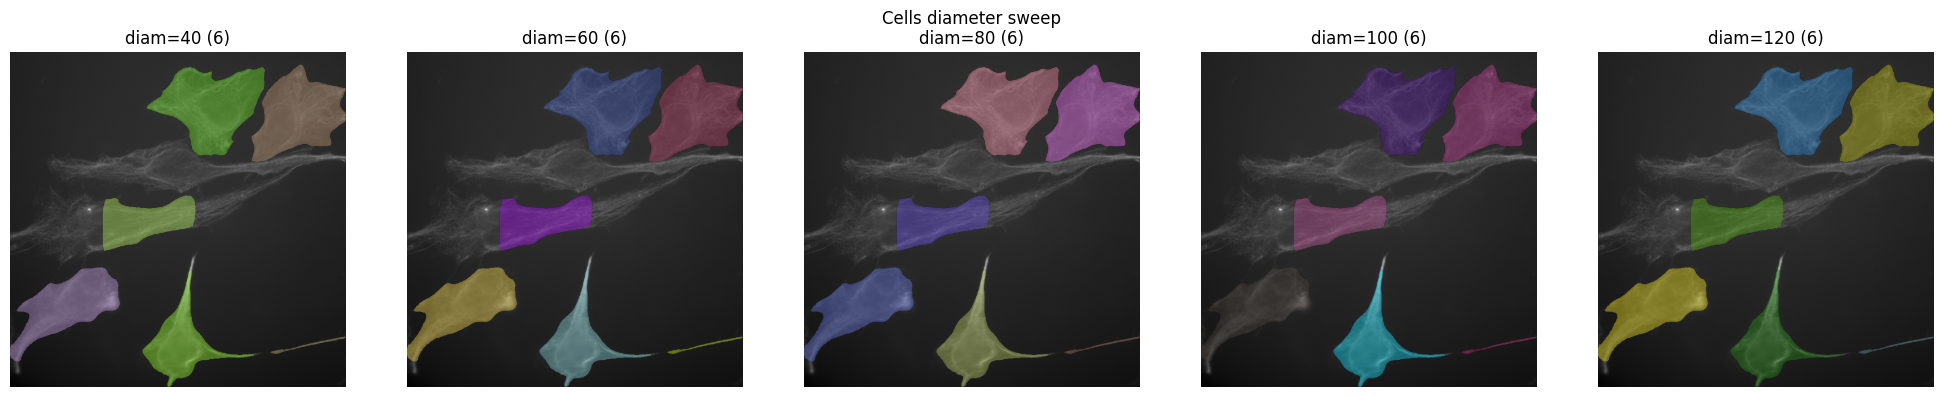

In [10]:
# Parameter sweep (dual mode)
# Change SWEEP_TARGET and SWEEP_PARAM to test different parameters
if SEGMENTATION_MODE == "dual":
    SWEEP_TARGET = "cells"  # "nuclei" or "cells"
    SWEEP_PARAM = "diameter"  # "diameter", "flow", or "cellprob"

    # Define sweep values for each parameter
    sweep_values = {
        "nuclei": {
            "diameter": [10, 15, 20, 25, 30],
            "flow": [0.2, 0.4, 0.6, 0.8],
            "cellprob": [-1.0, 0.0, 1.0, 2.0],
        },
        "cells": {
            "diameter": [40, 60, 80, 100, 120],
            "flow": [0.2, 0.4, 0.6, 0.8],
            "cellprob": [-1.0, 0.0, 1.0, 2.0],
        },
    }
    values = sweep_values[SWEEP_TARGET][SWEEP_PARAM]
    display_img = image[NUCLEI_CHANNEL if SWEEP_TARGET == "nuclei" else CYTO_CHANNEL]

    fig, axes = plt.subplots(1, len(values), figsize=(4 * len(values), 4))

    for i, v in enumerate(values):
        # Build kwargs with current value overridden
        kwargs = dict(
            nuclei_diameter=NUCLEI_DIAMETER,
            cell_diameter=CELL_DIAMETER,
            nuclei_flow_threshold=NUCLEI_FLOW_THRESHOLD,
            cell_flow_threshold=CELL_FLOW_THRESHOLD,
            nuclei_cellprob_threshold=NUCLEI_CELLPROB_THRESHOLD,
            cell_cellprob_threshold=CELL_CELLPROB_THRESHOLD,
        )
        kwargs[
            f"{SWEEP_TARGET}_{SWEEP_PARAM if SWEEP_PARAM != 'cellprob' else 'cellprob_threshold'}"
            if SWEEP_PARAM != "diameter"
            else f"{SWEEP_TARGET}_diameter"
        ] = v
        if SWEEP_PARAM == "flow":
            kwargs[f"{SWEEP_TARGET}_flow_threshold"] = v
        elif SWEEP_PARAM == "cellprob":
            kwargs[f"{SWEEP_TARGET}_cellprob_threshold"] = v
        else:
            kwargs[f"{SWEEP_TARGET}_diameter"] = v

        nuc_masks, cell_masks_test = segment_nuclei_and_cells(
            image,
            nuclei_channel=NUCLEI_CHANNEL,
            cyto_channel=CYTO_CHANNEL,
            cell_model=CELL_MODEL,
            nuclei_model=NUCLEI_MODEL,
            nuclei_diameter=kwargs["nuclei_diameter"],
            cell_diameter=kwargs["cell_diameter"],
            nuclei_flow_threshold=kwargs["nuclei_flow_threshold"],
            cell_flow_threshold=kwargs["cell_flow_threshold"],
            nuclei_cellprob_threshold=kwargs["nuclei_cellprob_threshold"],
            cell_cellprob_threshold=kwargs["cell_cellprob_threshold"],
            gpu=GPU,
            remove_edge_cells=REMOVE_EDGE_CELLS,
        )

        masks_show = nuc_masks if SWEEP_TARGET == "nuclei" else cell_masks_test
        n = len(np.unique(masks_show)) - 1

        axes[i].imshow(display_img, cmap="gray")
        axes[i].imshow(masks_show, cmap=make_mask_cmap(masks_show), alpha=0.4)
        axes[i].set_title(f"{SWEEP_PARAM[:4]}={v} ({n})")
        axes[i].axis("off")

    plt.suptitle(f"{SWEEP_TARGET.title()} {SWEEP_PARAM} sweep")
    plt.tight_layout()
    plt.show()
else:
    print("Skip this cell for nuclei/cells mode.")

---
## 6. Generate Batch Config

**Once you're happy with the parameters above, run this cell to generate the config file.**

No manual editing required - the config uses all the parameters from Section 2.

In [11]:
from goudacell.config import DualSegmentationParams, SegmentationConfig

# Config uses paths relative to where config file is saved (INPUT_DIR)
# SLURM script will cd to config dir before running
relative_input = "."
relative_output = "./masks"

# Build config based on mode
if SEGMENTATION_MODE == "dual":
    dual_params = DualSegmentationParams(
        nuclei_channel=NUCLEI_CHANNEL,
        cyto_channel=CYTO_CHANNEL,
        nuclei_diameter=NUCLEI_DIAMETER,
        cell_diameter=CELL_DIAMETER,
        cell_model=CELL_MODEL,
        nuclei_model=NUCLEI_MODEL,
        nuclei_flow_threshold=NUCLEI_FLOW_THRESHOLD,
        nuclei_cellprob_threshold=NUCLEI_CELLPROB_THRESHOLD,
        cell_flow_threshold=CELL_FLOW_THRESHOLD,
        cell_cellprob_threshold=CELL_CELLPROB_THRESHOLD,
    )
    config = SegmentationConfig(
        input_dir=relative_input,
        output_dir=relative_output,
        file_pattern=FILE_PATTERN,
        model=CELL_MODEL,
        diameter=CELL_DIAMETER,
        channels=[0, 0],
        flow_threshold=CELL_FLOW_THRESHOLD,
        cellprob_threshold=CELL_CELLPROB_THRESHOLD,
        gpu=GPU,
        remove_edge_cells=REMOVE_EDGE_CELLS,
        z_project=Z_PROJECT,
        channel_to_segment=None,
        mode="dual",
        dual=dual_params,
    )
elif SEGMENTATION_MODE == "nuclei":
    config = SegmentationConfig(
        input_dir=relative_input,
        output_dir=relative_output,
        file_pattern=FILE_PATTERN,
        model=NUCLEI_MODEL,
        diameter=NUCLEI_DIAMETER,
        channels=[0, 0],
        flow_threshold=NUCLEI_FLOW_THRESHOLD,
        cellprob_threshold=NUCLEI_CELLPROB_THRESHOLD,
        gpu=GPU,
        remove_edge_cells=REMOVE_EDGE_CELLS,
        z_project=Z_PROJECT,
        channel_to_segment=NUCLEI_CHANNEL,
        mode="nuclei",
    )
else:  # cells mode
    config = SegmentationConfig(
        input_dir=relative_input,
        output_dir=relative_output,
        file_pattern=FILE_PATTERN,
        model=CELL_MODEL,
        diameter=CELL_DIAMETER,
        channels=[0, 0],
        flow_threshold=CELL_FLOW_THRESHOLD,
        cellprob_threshold=CELL_CELLPROB_THRESHOLD,
        gpu=GPU,
        remove_edge_cells=REMOVE_EDGE_CELLS,
        z_project=Z_PROJECT,
        channel_to_segment=CYTO_CHANNEL,
        mode="cells",
    )

# Save config in input data directory
config_path = (INPUT_DIR / "segmentation_config.yaml").resolve()
config.to_yaml(config_path)

print(f"Config saved to: {config_path}")
print()
print("=" * 50)
print("To run batch segmentation:")
print("=" * 50)
print(f"sbatch scripts/run_segmentation.sh {config_path}")

Config saved to: /lab/barcheese01/mdiberna/goudacell/data/segmentation_config.yaml

To run batch segmentation:
sbatch scripts/run_segmentation.sh /lab/barcheese01/mdiberna/goudacell/data/segmentation_config.yaml


In [12]:
# Preview the generated config
print("Generated config:")
print("=" * 50)
print(config_path.read_text())

Generated config:
input_dir: .
output_dir: ./masks
file_pattern: '*.tif'
model: cpsam
diameter: 40.0
channels:
- 0
- 0
flow_threshold: 0.4
cellprob_threshold: 0.0
gpu: true
remove_edge_cells: false
z_project: true
channel_to_segment: null
mode: dual
dual:
  nuclei_channel: 1
  cyto_channel: 0
  nuclei_diameter: 15.0
  cell_diameter: 40.0
  cell_model: cpsam
  nuclei_model: cpsam
  nuclei_flow_threshold: 0.4
  nuclei_cellprob_threshold: 0.0
  cell_flow_threshold: 0.4
  cell_cellprob_threshold: 0.0



---
## 7. Save Test Results (Optional)

In [13]:
from goudacell import save_mask

if SEGMENTATION_MODE == "dual":
    # Save both masks for dual mode
    nuclei_output = OUTPUT_DIR / f"{test_image_path.stem}_nuclei_mask.tif"
    cell_output = OUTPUT_DIR / f"{test_image_path.stem}_cell_mask.tif"
    save_mask(nuclei_masks, nuclei_output)
    save_mask(cell_masks, cell_output)
    print(f"Saved nuclei mask to: {nuclei_output}")
    print(f"Saved cell mask to: {cell_output}")
elif SEGMENTATION_MODE == "nuclei":
    test_output = OUTPUT_DIR / f"{test_image_path.stem}_nuclei_mask.tif"
    save_mask(masks, test_output)
    print(f"Saved nuclei mask to: {test_output}")
else:
    test_output = OUTPUT_DIR / f"{test_image_path.stem}_mask.tif"
    save_mask(masks, test_output)
    print(f"Saved test mask to: {test_output}")

Saved nuclei mask to: ../data/masks/MAX_cyc_vimentin_PML_EdU_1_P1_R3D_nuclei_mask.tif
Saved cell mask to: ../data/masks/MAX_cyc_vimentin_PML_EdU_1_P1_R3D_cell_mask.tif


---
## 8. Feature Extraction (Optional)

Extract CellProfiler-equivalent features from segmented cells. Features include:
- **Intensity**: mean, std, min, max, integrated, median, quartiles, edge intensities
- **Shape**: area, perimeter, solidity, eccentricity, Zernike moments, Hu moments
- **Texture**: Haralick (13 features), PFTAS (54 features)
- **Distribution**: radial intensity distribution
- **Correlation**: channel-to-channel correlation, colocalization metrics
- **Neighbors**: neighbor counts, distances, angles

**Note**: Texture features (Haralick, PFTAS) are computationally expensive. Set `include_texture=False` for faster extraction.

In [14]:
# ============================================
# FEATURE EXTRACTION CONFIGURATION
# ============================================
EXTRACT_FEATURES = True  # Set to True to run feature extraction

# Channel names for feature column labeling (must match number of channels in image)
CHANNEL_NAMES = ["Vimentin", "DAPI", "PML", "EdU"]  # Customize for your channels

# Feature options (set to False for faster extraction)
INCLUDE_TEXTURE = True  # Haralick and PFTAS texture features
INCLUDE_CORRELATION = True  # Channel correlation and colocalization
INCLUDE_NEIGHBORS = True  # Neighbor measurements

if EXTRACT_FEATURES:
    from goudacell import extract_features

    # Use nuclei_masks and cell_masks from segmentation (Section 4)
    # For nuclei-only mode, pass cell_masks=None
    if SEGMENTATION_MODE == "dual":
        nuc = nuclei_masks
        cells = cell_masks
    elif SEGMENTATION_MODE == "nuclei":
        nuc = masks
        cells = None
    else:  # cells mode
        nuc = masks  # Use cell masks as nuclei (single compartment)
        cells = None

    print("Extracting features...")
    features_df = extract_features(
        image,
        nuclei_masks=nuc,
        cell_masks=cells,
        channel_names=CHANNEL_NAMES,
        include_texture=INCLUDE_TEXTURE,
        include_correlation=INCLUDE_CORRELATION,
        include_neighbors=INCLUDE_NEIGHBORS,
    )

    print(f"Extracted {len(features_df)} cells x {len(features_df.columns)} features")
    print("\nFeature columns preview:")
    print(features_df.columns.tolist()[:20], "...")
    print("\nDataFrame head:")
    display(features_df.head())

    # Save features
    features_output = OUTPUT_DIR / f"{test_image_path.stem}_features.csv"
    features_df.to_csv(features_output, index=False)
    print(f"\nSaved features to: {features_output}")
else:
    print("Feature extraction disabled. Set EXTRACT_FEATURES = True to enable.")

Extracting features...


/lab/barcheese01/mdiberna/goudacell/src/goudacell/cp_emulator.py:239: FutureWarning: `RegionProperties.intensity_image` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.image_intensity` instead. 
  "int": lambda r: r.intensity_image[r.image, ...].sum(axis=0),
/lab/barcheese01/mdiberna/goudacell/src/goudacell/cp_emulator.py:240: FutureWarning: `RegionProperties.intensity_image` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.image_intensity` instead. 
  "mean": lambda r: r.intensity_image[r.image, ...].mean(axis=0),
/lab/barcheese01/mdiberna/goudacell/src/goudacell/cp_emulator.py:241: FutureWarning: `RegionProperties.intensity_image` is deprecated starting in version 0.26 and will be removed in version 2.0. Use `RegionProperties.image_intensity` instead. 
  "std": lambda r: np.std(r.intensity_image[r.image, ...], axis=0),
/lab/barcheese01/mdiberna/goudacell/src/goudacell/cp_emulator.py:242: 

Extracted 6 cells x 1649 features

Feature columns preview:
['label', 'nucleus_DAPI_center_mass_c', 'nucleus_DAPI_center_mass_r', 'nucleus_DAPI_frac_at_d_0', 'nucleus_DAPI_frac_at_d_1', 'nucleus_DAPI_frac_at_d_2', 'nucleus_DAPI_frac_at_d_3', 'nucleus_DAPI_haralick_5_0', 'nucleus_DAPI_haralick_5_1', 'nucleus_DAPI_haralick_5_10', 'nucleus_DAPI_haralick_5_11', 'nucleus_DAPI_haralick_5_12', 'nucleus_DAPI_haralick_5_2', 'nucleus_DAPI_haralick_5_3', 'nucleus_DAPI_haralick_5_4', 'nucleus_DAPI_haralick_5_5', 'nucleus_DAPI_haralick_5_6', 'nucleus_DAPI_haralick_5_7', 'nucleus_DAPI_haralick_5_8', 'nucleus_DAPI_haralick_5_9'] ...

DataFrame head:


/lab/barcheese01/mdiberna/goudacell/src/goudacell/cp_emulator.py:895: FutureWarning: `binary_dilation` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.dilation` instead. Note the lack of mirroring for non-symmetric footprints (see docstring notes).
  dilated = skimage.morphology.binary_dilation(
/lab/barcheese01/mdiberna/goudacell/src/goudacell/cp_emulator.py:902: FutureWarning: `binary_dilation` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.dilation` instead. Note the lack of mirroring for non-symmetric footprints (see docstring notes).
  dilated_neighbors = skimage.morphology.binary_dilation(
/lab/barcheese01/mdiberna/goudacell/src/goudacell/cp_emulator.py:895: FutureWarning: `binary_dilation` is deprecated since version 0.26 and will be removed in version 0.28. Use `skimage.morphology.dilation` instead. Note the lack of mirroring for non-symmetric footprints (see docstring notes).
  dilated

,label,nucleus_DAPI_center_mass_c,nucleus_DAPI_center_mass_r,nucleus_DAPI_frac_at_d_0,nucleus_DAPI_frac_at_d_1,nucleus_DAPI_frac_at_d_2,nucleus_DAPI_frac_at_d_3,nucleus_DAPI_haralick_5_0,nucleus_DAPI_haralick_5_1,nucleus_DAPI_haralick_5_10,...,cytoplasm_zernike_8_0,cytoplasm_zernike_8_2,cytoplasm_zernike_8_4,cytoplasm_zernike_8_6,cytoplasm_zernike_8_8,cytoplasm_zernike_9_1,cytoplasm_zernike_9_3,cytoplasm_zernike_9_5,cytoplasm_zernike_9_7,cytoplasm_zernike_9_9
0,1,62.523811,50.654723,0.049056,0.187274,0.350121,0.413550,0.001664,53.818191,3.864098,...,0.078033,0.081492,0.045705,0.079850,0.067262,0.062591,0.027244,0.042931,0.031569,0.025256
1,2,43.234243,57.281163,0.061285,0.221780,0.359399,0.357536,0.000786,148.352939,4.603452,...,0.007011,0.063969,0.039656,0.079803,0.052700,0.109572,0.129982,0.029186,0.022319,0.025129
2,3,75.230721,48.389600,0.053710,0.194085,0.356995,0.395211,0.001351,96.125710,4.283792,...,0.019535,0.122691,0.059489,0.130411,0.069115,0.035078,0.040762,0.094495,0.048027,0.051412
3,4,57.748103,59.665842,0.052054,0.187424,0.343697,0.416824,0.001684,47.720656,3.832698,...,0.028366,0.089148,0.146790,0.141880,0.072916,0.060783,0.068859,0.099870,0.079476,0.045067
4,5,55.331775,50.367944,0.050224,0.178731,0.346674,0.424370,0.001193,86.112348,4.259637,...,0.000218,0.257314,0.134210,0.048405,0.065621,0.163316,0.236280,0.237363,0.087655,0.050501



Saved features to: ../data/masks/MAX_cyc_vimentin_PML_EdU_1_P1_R3D_features.csv
